# Data Science for Economics Final Assignment
|Name|SNR|ANR|
|---|---|----|
|Alexandros Marios Mistillioglou|2062448|u360743|

# Table of Contents:
   1. Research Question
   2. Motivation
   3. Method and Data
   4. Preview of the Answers
   5. Main Assumptions
   6. Python Code 
   7. Robustness Analysis
   8. Discussion and Conclussion

# 1. Research Question

   The research question that we have picked for this project is: <b>Is it possible to use machine learning to predict the tourist arrivals of each country on a monthly basis?<b>
    
   With this assignment we will assess whether it is feasible to predict the future tourist arrivals in each country with machine learning techniques. 

# 2. Motivation

   As the impact of the Covid-19 pandemic is receding, life returns to normality. Along with that, leisure travelling is showing a strong rebound, and already problems of over-tourism are starting to reappear. A prime example of this occasion is Venice, with some 20 million visitors flooding each year. On its busiest days, around 120,000 people visit this city which is home to just 55,000 permanent residents. This creates enormous issues, from increased rents for the locals to the overstrain of the infrastructures and the damage to historic buildings. This led Venice to adopt a rather extreme measure, as it is the first city in the world that, from January of 2023, will charge visitors 10 euros as an entrance fee. 
   The results of this policy remain to be seen however, another useful tool for the policymakers would be the ability to accurately predict the number of tourists that are expected to visit each month in order to attempt to implement policies that would alleviate this issue by spreading the amount of tourists throughout the year. For this purpose, we will use the datasets of Eurostat in order to train the neural networks to predict future tourist arrivals.  

In [1]:
#Libraries Importing

import matplotlib as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


# 3. Method and Data

   The datasets we use came from Eurostat and include data on the tourist arrivals in each EU country over the last two decades. (2002-2020) https://ec.europa.eu/eurostat/databrowser/bookmark/5c30d775-885d-48ec-81fe-efaf3c0f09ce?lang=en The reason that we used data up to 2020 is that as the Covid-19 pandemic had a massive impact to the tourism industry, including more recent datasets would inevitably lead to misleading results. 
   Prior to using the data for the regression and the attempt to use the different machine learning techniques, we need to do the appropriate data cleaning. As the first step, it is essential to mention that from the datasets, we choose a 75% threshold for dropping independent variables meaning we only keep countries that originally contain 75% and above values that are non-missing and for those we proceed to fill the missing values by imputing the mean and replacing the missing values with it. The value of 75% was chosen based on intuition as the general rule is to keep variables with 20-30% missing values. This was done in order to preserve and keep as much of the original data as possible.
   By imputing with the mean, we aim to preserve the mean of the observed data, while being able to keep our data size up to almost the full size. Additionally, if the data are missing completely in random, by using the mean, we are able to keep the estimate of the mean itself unbiased. Thus, the imputation we perform yields unbiased estimates and we avoid ignoring data that contains potential useful information for our models.
   In this assignment we will use as methods the OLS, Ridge and Lasso regressions as well as neural networks. We choose these mix of methods for this assignement as they are complimentary to each other and ensure the robustness and credibility of our results, as we will explain in further detail below.

In [2]:
#Reading the data into pandas dataframes

df = pd.read_excel(r"C:\Users\Alex\Desktop\Second Sem Tilb\Data science\Tourism stuff\Datasets\tour_occ_arm__custom_3198776_page_spreadsheet.xlsx")

df.drop(list(df.filter(regex = 'Unnamed')), axis = 1, inplace = True)

df.replace(':', np.nan,inplace=True)

df = df.transpose()

df.dropna(axis=1, thresh=len(df)*0.75,  inplace=True)

new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df.columns = new_header #set the header row as the df header

# Used to find percentage of missing values per column
# amount_missing = df.isnull().sum() / df.shape[0] * 100.00

df.fillna(df.mean(), inplace=True)

# df.dtypes all are float

# 4. Preview of the Answers

Based on our results, it is reasonable to claim that machine learning techniques, such as simple Feed-Forward Neural networks, OLS, ridge and lasso regressions allow us to predict the future tourist arrivals in each EU country for each month. Generally, all the models give robust resutls with at least 0.94 R-squared. 

# 5. Main Assumptions

   Regarding the assumptions that we have to make, the most vital one would be that it is assumed that our datasets are representative samples and would allow us to predict the future with a degree of certainty. Having excluded the time since the start of the pandemic, it is reasonable to assume that there was no significant disruption in the tourist arrivals in the countries of our datasets, with the exception to some terrorist attacks, that had only a rather small and short-term effect on the arrivals. Additionally, a rather safer assumption that we have to make is about the reliability of our data source, but as the data source is from the Eurostat, it is assumed that it is as reliable as it can be. Finally, we assume that as all the countries are performing in a similar way, if a method works for one country, it would also work for all the others in our datasets.
   Regarding the methods that we are using, the key assumption would be that they are indeed able to provide robustness checks and there is minimal or no multicollinearity among the independent variables. Usually it requires a large sample size to predict properly and thus we assume that the observations are independent of each other.

In [3]:
def OLS_data_prep_results(data,country_to_predict,index_of_country_to_predict,lag_of_country_to_predict):
    
    """
    Prepares the data from a dataframe to apply the OLS and then returns the results of the OLS

    Args:
        data: The dataframe for which we want to apply OLS
        country_to_predict: The country we want to to do a linear regression
        index_of_country_to_predict: The index of the country in the dataframe
        lag_of_country_to_predict:The lag we want to implement, meaning which values we want to use for the linear regression

    Returns:
        The results of the OLS 
    
    """
    
    #Lagging the attribute we want to predict and dropping last row

    data[country_to_predict] = data[country_to_predict].shift(lag_of_country_to_predict)

    data.dropna(inplace = True)

    #Scaling Data

    data_to_be_scaled = data.to_numpy()

    scaler = MinMaxScaler(feature_range= (0,1)) #Initiating the scaler
    data_scaled = scaler.fit_transform(data_to_be_scaled)

    # Splitting the data to x and y

    y = data_scaled[:,index_of_country_to_predict]
    X = np.delete(data_scaled, index_of_country_to_predict, axis=1)

    X2 = sm.add_constant(X) # adding a constant

    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary()) # This allows us to actually see the model


In [13]:
def Neural_Network_Structure(shape_for_first_layer):
    
    """
    Createsand compiles a Feed-Forward Neural Network
    
    Args:
        shape_for_first_layer: The input shape for the neural network

    Returns:
        model: The neural network as specified withing the function
    
    """
    
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(54, input_shape = shape_for_first_layer ))

    model.add(tf.keras.layers.Dense(108,activation= "sigmoid"))
    
    model.add(tf.keras.layers.Dense(54,activation= "sigmoid"))
    
    
    model.add(tf.keras.layers.Dense(1))
    

    
    
    # Compile the model
    
    model.compile(loss = tf.keras.losses.MeanSquaredError(),\
                  metrics=tf.keras.metrics.RootMeanSquaredError(),\
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2))
    
    return model

# 6. Python code

## OLS Regression

Below we are using Greece as a testing case to see if our variables allow predicting the dependent variable. Greece as one of the prime tourism destination of our dataset, is the ideal case for this purpose. Of course, this could be replicated with all the other countries of our datasets. Regarding the other independent variables in this case, we are considering the other comparable countries in Europe and how are they performing in this case. 

In [6]:
#Applying OLS Function

OLS_data_prep_results(df,"Greece",7,12)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     361.6
Date:                Sun, 14 Aug 2022   Prob (F-statistic):          1.64e-139
Time:                        18:45:38   Log-Likelihood:                 430.52
No. Observations:                 204   AIC:                            -805.0
Df Residuals:                     176   BIC:                            -712.1
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0487      0.016     -3.047      0.0

As the OLS regression gives an R-squared of 0.982, it shows that the independent variables that we are using are explaining our dependent variable. This may seem like a great thing as it indicates that our model works exceptionally well. Despite that, high R-squared can also be interpreted as a problem, as it may mean overfitting of our model or bias. In our case, the most expected reasoning behind this exceptionally high number is the fact that we have clear trends in our data. This is not expected to be a significant problem, as we have used lagging in addressing it.

## Scaling

For the methods that we split the data into training and testing, we fit the scaler with training data and then transform both the training and testing data in order to avoid creating bias in our results by including information from the testing datasets into the training process of our methods. For the country that we would like to predict, we are lagging the tourist arrivals value by a year, which means that we are using last year's monthly arrivals to predict the same month in the following year.

It's important to scale data within a certain range before using it in a neural network. Not doing so can result in the network getting stuck in a flat region and not learning or experiencing numerical issues, particularly during weight initialization. This is due to the varying input ranges of the variables included in the model, so it's important to consider this when prepping data for neural networks.

For the scaler we used Tensorflow's MinMaxScaler that adjusts each feature to a specific range individually. This can be shown mathematically as :


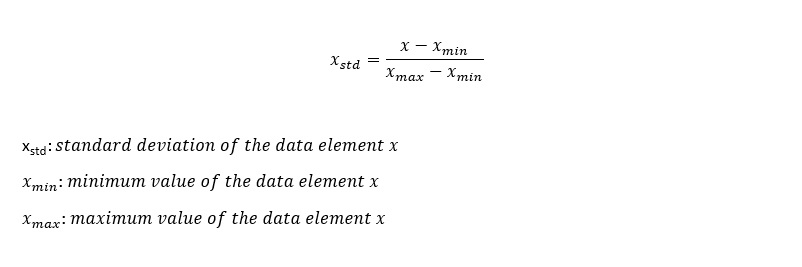

Following the calculation of Xstd :

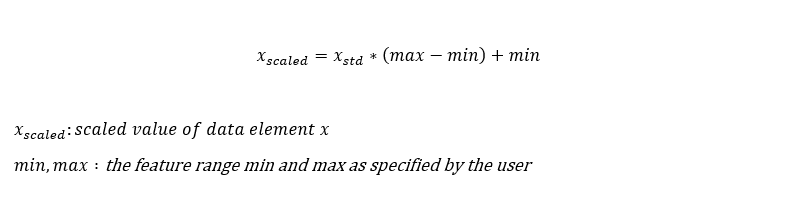

The scaling algorithm's range was set to be between 0 and 1. The scaler was trained on the training data's features and was also applied to the test data, so that it is scaled using the same feature values as the training data.

In [7]:
#spliting to train,validation,test data , validation size = 10% , test size = 10%

df["Greece"] = df["Greece"].shift(12)

df.dropna(inplace = True)

data_to_be_scaled = df.to_numpy()

ML_x = np.delete(data_to_be_scaled, 7, axis=1)

ML_y = data_to_be_scaled[:,7]

X_train, X_test, y_train, y_test = train_test_split(ML_x, ML_y, test_size=0.1, random_state=50)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=50)

#Scaling our data

scaler_X = MinMaxScaler(feature_range= (0,1))

scaler_X.fit(X_train)

X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler(feature_range= (0,1))

scaler_y.fit(y_train.reshape(-1, 1))

y_train_scaled = scaler_y.transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))



## Neural Networks

The first and third layer include 54 neurons each, while the second one uses 108. In addition, each layer except the first includes a sigmoid activation function.Below we explain the several choices regarding the neural network structure

Layers

The decision behind the amount of hidden layers of the neural network and the neurons per layer is of vital importance in constructing a neural network, as it heavily affects their ability to produce results. Experimentation is required in order to reach the final structure. Therefore, we used an arbitrary structure based on intuition to start and then, through experiments, we reached this structure that produced the best results in comparison with the previous attempts.


Activation functions

The activation function we chose to include in the neural network is the sigmoid, which is a unique form of the logistic function. The sigmoid function can be a great asset as it allows for a straightforward interpretation of the neuron process. This can be expressed by the function below and shown in following figure:



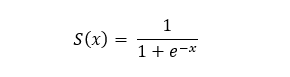

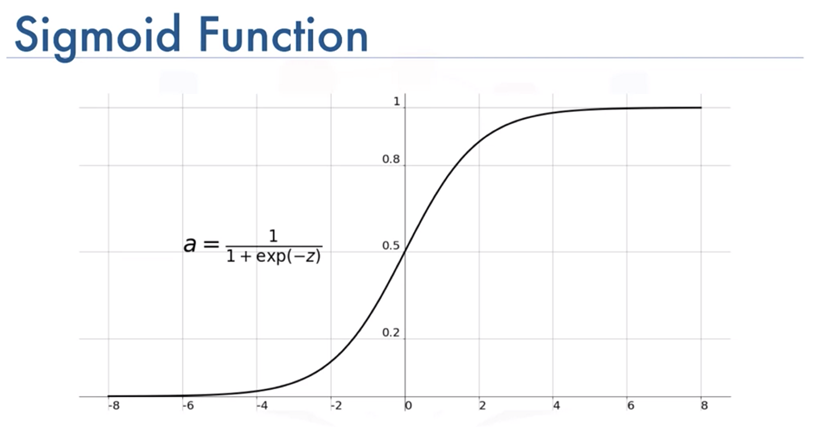

Loss function 

Regarding the loss function, we are using the root-mean-square error (RMSE). This measures the differences between values predicted by a model or an estimator and observed values. The Root Mean Squared Error (RMSE) is a measure of accuracy that calculates the average difference between predicted values and actual values. These differences are called residuals when calculated using the data sample used for estimation and errors or prediction errors when calculated using new data. The RMSE aggregates these differences into a single value to compare the performance of different forecasting models for a specific dataset, but cannot be used to compare between datasets as it is influenced by the scale of the data.

The Root Mean Squared Error (RMSE) is a measure that calculates the average difference between predicted values and actual values. It is always non-negative, and a value of 0, which is rarely achieved in practice, would indicate a perfect fit to the data. In general, a lower RMSE is considered better. However, it is not valid to compare RMSEs across different data types as the measure depends on the scale of the numbers used. RMSE is calculated by taking the square root of the average of the squared errors. The impact of each error on the RMSE is proportional to the size of the squared error, meaning larger errors have a greater impact. Therefore, RMSE is sensitive to outliers, which can greatly affect the overall value.


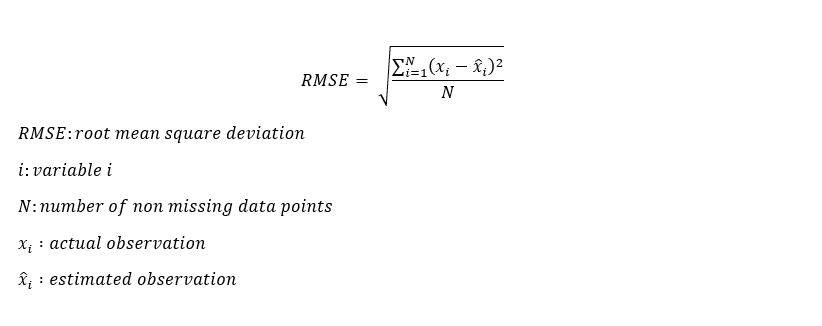

Optimizers

Optimization improves how a neural network learns by adjusting the model's hyperparameters iteratively to find the best solution for a given function. Optimization aims to produce a more accurate model with a lower error rate. The Keras sequential model, which is the foundation of the neural network, uses a process called backpropagation as the optimization method. Backpropagation uses the gradient descent approach to calculate the gradient of the error with respect to the network's weights and proceeds backwards through the network, allowing for more efficient computation of the gradient at each layer.

We have chosen to use the Adaptive Moment Estimation (Adam) algorithm as the optimizer for the neural network. Adam combines two gradient descent techniques, Momentum and Root Mean Square Propagation (RMSP). Additionally, compared to other options available in the Keras sequential model, Adam is computationally more efficient and requires less memory.

To understand how Adam works, it is first essential to understand the Momentum and RMSP methods combined. Momentum helps speed up the gradient descent algorithm by considering the exponentially weighted average of the gradients.


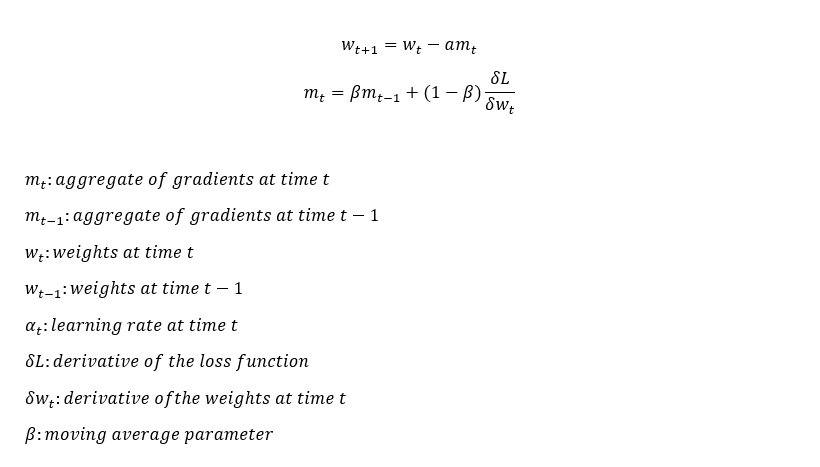

RMSP is an adaptive learning algorithm that uses the exponential moving average of the gradients:

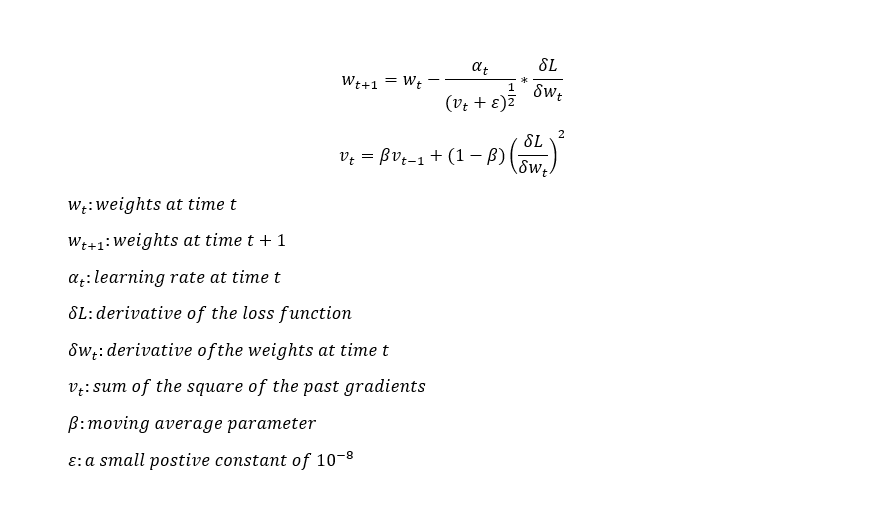

By using the above two formulas, we arrive at:

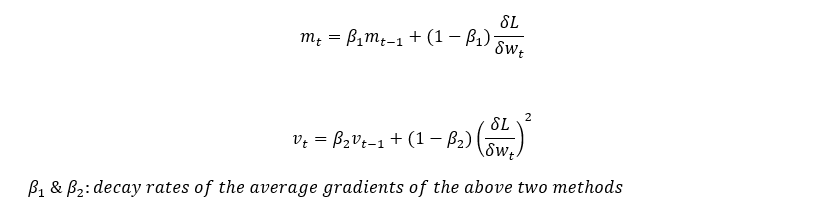

Adam addresses an issue where m_t and v_t are initialized as 0 and therefore tend to be biased towards 0 since both β1 and β2 are approximately 1. By computing bias-corrected versions of mt and vt, Adam allows for better control of the weights and prevents high oscillations when the global minimum is near. Therefore:

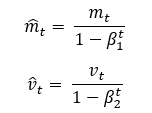

Instead of using mt and vt, Adam uses bias-corrected versions of these parameters

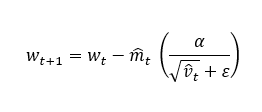

Epochs, Batch size and Early stopping

An epoch is a complete pass through all the training data, using all the data once. In a neural network that uses backpropagation, one cycle of training includes both the forward pass and the backward pass. Epochs are made up of one or more batches, where a portion of the data is used to train the network in each batch.

During training, the goal is to reduce the error rate by adjusting the parameters while also ensuring the network can handle new data. It's important to balance the tradeoff between bias and variance, as too much of either can lead to poor performance. Overfitting occurs when the model is too complex and fits the training data perfectly but doesn't perform well on new data, while underfitting happens when the model is too simple and doesn't capture the patterns in the training data.


Early stopping algorithm is used to prevent overfitting by monitoring the performance measure and stopping the training process once the trigger is activated, saving the best hyperparameters. It's set to monitor validation loss with patience of 4, meaning training stops if validation loss doesn't improve in 4 epochs.

We chose a small batch size of 20 for efficiency during training.

In [14]:

model1 = Neural_Network_Structure((27,))


model1_fit = model1.fit(
    X_train_scaled,y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    batch_size= 20,
    epochs=40,
    verbose= 1,
    callbacks= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4),
    )


y_pred = model1.predict(X_test_scaled)

r2_score(y_test_scaled, y_pred)

Epoch 1/40
8/8 [==============================] - 1s 40ms/step - loss: 0.6767 - root_mean_squared_error: 0.8226 - val_loss: 0.3342 - val_root_mean_squared_error: 0.5781
Epoch 2/40
8/8 [==============================] - 0s 7ms/step - loss: 0.2376 - root_mean_squared_error: 0.4875 - val_loss: 0.1892 - val_root_mean_squared_error: 0.4349
Epoch 3/40
8/8 [==============================] - 0s 6ms/step - loss: 0.0929 - root_mean_squared_error: 0.3048 - val_loss: 0.0810 - val_root_mean_squared_error: 0.2846
Epoch 4/40
8/8 [==============================] - 0s 7ms/step - loss: 0.0397 - root_mean_squared_error: 0.1992 - val_loss: 0.0357 - val_root_mean_squared_error: 0.1889
Epoch 5/40
8/8 [==============================] - 0s 7ms/step - loss: 0.0230 - root_mean_squared_error: 0.1517 - val_loss: 0.0277 - val_root_mean_squared_error: 0.1665
Epoch 6/40
8/8 [==============================] - 0s 6ms/step - loss: 0.0194 - root_mean_squared_error: 0.1392 - val_loss: 0.0182 - val_root_mean_squared_error

0.9644712770569116

As we can see the R-squared is 0.964, which is good as it shows that it machine learning can indeed predict the future tourist arrivals with high degree of certainty. We decided not to continue training the model because the validation loss has plateaued and the actual loss has stabilized for the last 4 epochs, indicating that the model has reached its peak performance.

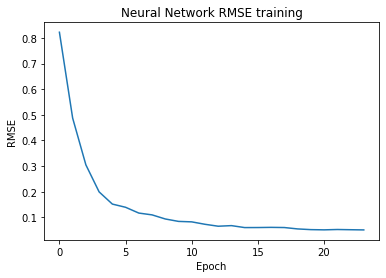

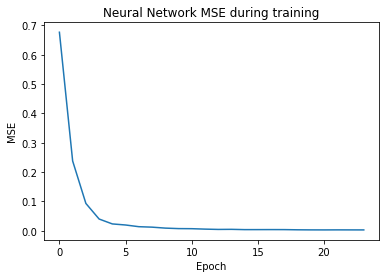

In [15]:
#Graph of the training

# Plot for Neural Network Training

plt.plot(model1_fit.history['root_mean_squared_error'])
plt.title('Neural Network RMSE training')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.show()

# summarize history for loss
plt.plot(model1_fit.history['loss'])
plt.title('Neural Network MSE during training')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

As we see above, the RMSE and the MSE are getting smaller with each Epoch. This indicates that the neural network is being trained successfully by our available datasets.

# 7. Robustness Analysis

For our Robustness analysis we will use Ridge and Lasso regression. Additionally, we perform the same scaling method as previously used for the neural network

In [16]:
#Ridge & Lasso Regression data prep
# We don't have a validation set in this case

X_train, X_test, y_train, y_test = train_test_split(ML_x, ML_y, test_size=0.1, random_state=50)

#Scaling our data

RL_scaler_X = MinMaxScaler(feature_range= (0,1))

RL_scaler_X.fit(X_train)

X_train_scaled = RL_scaler_X.transform(X_train)
X_test_scaled = RL_scaler_X.transform(X_test)

RL_scaler_y = MinMaxScaler(feature_range= (0,1))

RL_scaler_y.fit(y_train.reshape(-1, 1))

y_train_scaled = RL_scaler_y.transform(y_train.reshape(-1, 1))
y_test_scaled = RL_scaler_y.transform(y_test.reshape(-1, 1))



## Ridge Regression

We are using Ridge Regression, as it is a method of estimating the coefficients in cases that independent variables are highly correlated, as could be the tourist arrivals in different observations of our datasets. 

In [17]:
#Ridge Model setup & prediction

Ridge_model = Ridge(alpha=0.01)

Ridge_model.fit(X_train_scaled, y_train_scaled) 

pred_Ridge_model= Ridge_model.predict(X_test_scaled)

r2_score(y_test_scaled, pred_Ridge_model)

0.9930687054906027

The Rsquare score in this case shows the robustness of our results. Even though the ideal score in this case would be the a score of 1 or 100%, this is almost impossible to achieve with real-world datasets. Therefore our score of 0.99 or 99% strongly indicates that our results are indeed robust.

## Lasso Regression

Lasso Regression, also known as the Least Absolute Shrinkage and Selection Operator, is a variation of linear regression. It modifies the loss function to reduce the model's complexity by restricting the total of the absolute values of the coefficients.

In [18]:
#Lasso Model setup & prediction

Lasso_model = Lasso(alpha=0.01)

Lasso_model.fit(X_train_scaled, y_train_scaled) 

pred_Lasso_model= Lasso_model.predict(X_test_scaled)

r2_score(y_test_scaled, pred_Lasso_model)

0.9427722694529677

In the same light, Lasso regression gives an Rsquare score of 0.94 or 94%, and even though not as ideal as the case of the ridge regression above, this score still provides an additional proof regarding the robustness of our result.

# 8. Discussion and conclusion

As the R-square scores in the OLS, Ridge and Lasso regression are all more than 0.94, we can assume with confidence that our results are indeed robust and to answer the main question of this assignment, we can indeed use machine learning with publicly available data to predict future tourist arrivals each month.
Regarding the potential weakness of our method, the first thought has, of course, to go to the missing values, as we had to drop some countries with a large number of missing values and replace some of the remaining ones with the average. Despite that, as these occasions were rather limited, we believe that our results are indeed representative. In a future paper, this could be corrected by going to national sources for each country that had missing values instead of relying exclusively on datasets at a European level. 
Another possible way to expand on this paper would be to would be by using specific regions of countries, instead of taking the countries as a whole, by using, for example, the NUTS 2 regions that the European Commission is using for its policies. In this way, countries can use the results for domestic policies and redirect tourism to less crowded areas depending on the time of the year.
Finally, it may be very interesting to replicate it on a Worldwide level, as this would bring more diverse tourist destinations, but due to the rather more unstable political situation, it would require careful assessment of the other factors that may influence our results. 

